In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install seaborn
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans
import glacierml as gl
tf.random.set_seed(42)

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

currently running tensorflow version: 2.8.0


# ML Analysis

In [2]:
# select dataset to analyze

selected_dataset = 'df6'

if selected_dataset == 'df1':
    df1 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'n'
    )
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset
    
if selected_dataset == 'df2':
    df2 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df2 = df2.drop(['RGIId', 'region'], axis = 1)
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
    
if selected_dataset == 'df3':
    df3 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 25
    )
    df3 = df3.drop(['RGIId', 'region'], axis = 1)
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = 'df3'
    
if selected_dataset == 'df4':
    df4 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 75
    )
    df4 = df4.drop(['RGIId', 'region'], axis = 1)
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = 'df4'

if selected_dataset == 'df5':
    df5 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off',
    )
    df5 = df5.drop(['RGIId', 'region'], axis = 1)
    df5['Zdelta'] = df5['Zmax'] - df5['Zmin']
    module = 'sm5'
    res = 'sr5'
    dataset = df5
    dataset.name = 'df5'
    
if selected_dataset == 'df6':
    df6 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 25
    )
    df6 = df6.drop(['RGIId','region'], axis = 1)
    df6['Zdelta'] = df6['Zmax'] - df6['Zmin']
    module = 'sm6'
    res = 'sr6'
    dataset = df6
    dataset.name = 'df6'
    
    
if selected_dataset == 'df7':
    df7 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 75
    )
    df7 = df7.drop(['RGIId','region'], axis = 1)
    df7['Zdelta'] = df7['Zmax'] - df7['Zmin']
    module = 'sm7'
    res = 'sr7'
    dataset = df7
    dataset.name = 'df7'
dataset    

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,Zdelta
0,67.91500,18.56400,16.9,1204,1526,1698,1.438,98,1941,72.0,494
1,67.91000,18.49600,15.9,1207,1443,2070,3.696,282,3954,84.0,863
2,67.90300,18.56900,13.2,1143,1414,1797,3.405,102,3636,99.0,654
3,41.41401,-122.21133,21.5,3033,3492,4180,1.291,332,3168,20.0,1147
4,48.75239,-113.72706,17.2,1961,2039,2398,1.018,23,1560,64.0,437
...,...,...,...,...,...,...,...,...,...,...,...
193,77.97140,14.06910,10.1,195,336,521,6.737,56,3780,65.0,326
194,-3.05715,37.35070,9.9,5663,5771,5794,0.616,355,905,23.0,131
195,77.02720,15.48540,18.8,323,422,587,0.418,144,1084,27.0,264
196,78.87100,12.16140,13.8,123,388,684,5.016,350,4111,76.0,561


In [3]:
df6['Thickness'].mean()

55.92929292929293

In [ ]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
inputs = len(dataset.columns) - 1
print('total inputs = ' + str(total_inputs))
print('1/10 inputs = ' + str(0.1 * total_inputs))
print('1/2 inputs = ' + str(0.5 * total_inputs))
non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 4
layer_2 = 4


total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))

In [4]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()

for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    if 'deviations' in file:
        file_reader = pd.read_csv(rootdir + file)
        deviations = pd.concat([deviations, file_reader], ignore_index = True)

deviations = deviations.drop('Unnamed: 0', axis = 1)
predictions = predictions.drop('Unnamed: 0', axis = 1)
deviations['total parameters'] = deviations['total parameters'].astype(int)
deviations['trained parameters'] = deviations['trained parameters'].astype(int)
deviations['total inputs'] = deviations['total inputs'].astype(int)
deviations = deviations[
    (deviations['df'].str.contains(selected_dataset)) 
#     &
#     (deviations['layer architecture'] == '10-5')
    &
    (deviations['learning rate'] == 0.01)
#     &
#     (deviations['epochs'] == 999)
    &
    (deviations['dropout'] == 1)
]
deviations['test - train'] = (
    abs(deviations['test mae avg'] - deviations['train mae avg'])
)
deviations = deviations.sort_values(
    [
#         'layer architecture',
#         'test - train',
#         'epochs',
        'test mae avg', 
#         'train mae avg'
#         'test predicted thickness std dev'
#         'layer architecture',
#         'learning rate',
#         'df',
#         'layer architecture'
    ]
)
deviations['paramater ratio'] = deviations['trained parameters'] / deviations['total inputs']
deviations.sort_values('test mae avg')

100%|██████████| 28/28 [00:00<00:00, 351.02it/s]


,layer architecture,total parameters,trained parameters,total inputs,df,dropout,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev,test - train,paramater ratio
117,12-2,182,161,1980,df6,1,0.01,0.2,2000,16.005241,15.992185,4.313220,2.902292,5.832476,2.538545,0.013057,0.081313
115,10-2,156,135,1980,df6,1,0.01,0.2,2000,16.129885,16.212918,2.910639,2.951045,5.924893,2.671601,0.083033,0.068182
124,19-2,273,252,1980,df6,1,0.01,0.2,2000,16.401668,16.492264,4.416469,3.586303,5.907417,3.202037,0.090596,0.127273
119,14-2,208,187,1980,df6,1,0.01,0.2,2000,16.569044,16.165970,5.163596,2.748792,5.318226,2.721210,0.403074,0.094444
120,15-2,221,200,1980,df6,1,0.01,0.2,2000,16.597031,16.457753,4.458657,3.415319,5.931917,3.369287,0.139277,0.101010
110,5-2,91,70,1980,df6,1,0.01,0.2,2000,16.712669,16.767940,3.564043,2.782518,4.885577,2.583578,0.055270,0.035354
111,6-2,104,83,1980,df6,1,0.01,0.2,2000,16.818294,16.616719,4.669940,2.725752,4.647118,2.688298,0.201575,0.041919
118,13-2,195,174,1980,df6,1,0.01,0.2,2000,17.143249,16.929016,3.778563,3.708978,6.118735,3.044658,0.214233,0.087879
125,20-2,286,265,1980,df6,1,0.01,0.2,2000,17.214324,16.717058,4.834685,3.566955,6.135488,3.182216,0.497266,0.133838
123,18-2,260,239,1980,df6,1,0.01,0.2,2000,17.307084,17.157526,4.476792,3.823325,5.765307,3.236761,0.149557,0.120707


Text(0.5, 0, 'Trainable parameters / total inputs')

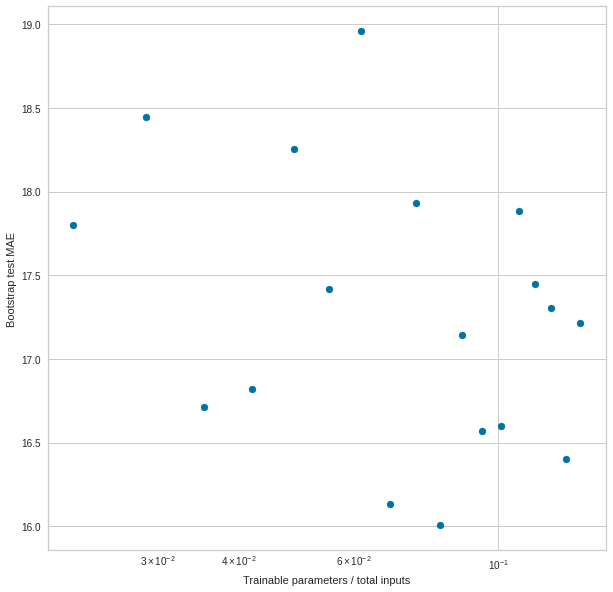

In [5]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
# plt.suptitle(
#     'Volume estimates using dataset coregistration ' + training_module +
#     ', layer architecture ' + arch +
#     ', learning rate: ' + str(top_learning_rate)
#              , fontsize=18, y=1
#             )
fig.patch.set_facecolor('w')
plt.scatter(
    deviations['paramater ratio'],
    deviations['test mae avg']
)
plt.xscale('log')
plt.ylabel('Bootstrap test MAE')
plt.xlabel('Trainable parameters / total inputs')

Please select index from deviations table to inspect further
124
19-2
0.01
2000
1
19-2
0.01
2000
1
figs/sm6/
saved_results/sr6/sr_19-2/


25it [00:07,  3.41it/s]


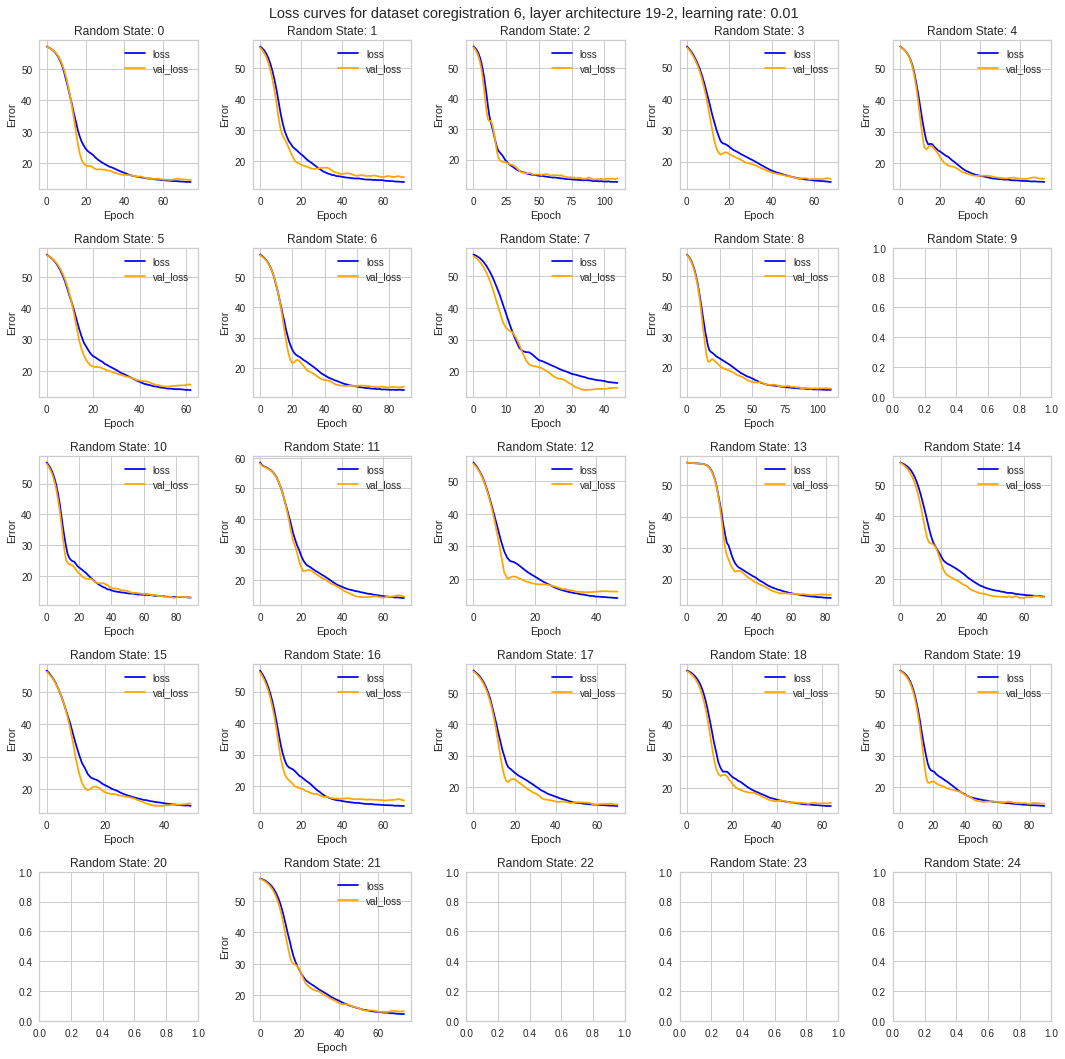

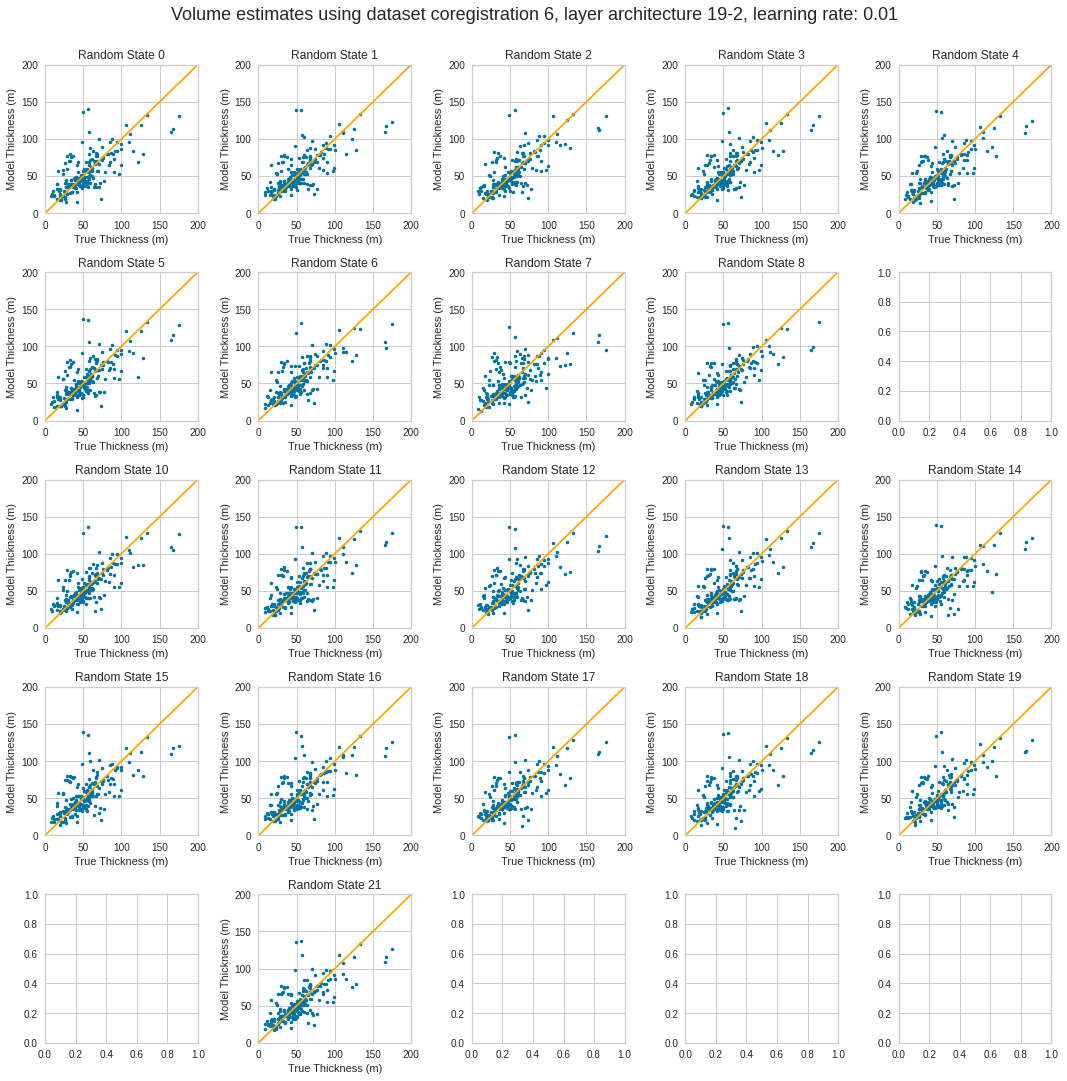

In [15]:
# load selected model and look at predicted accuracies of each random state
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dropout = deviations['dropout'].loc[selection]
training_module = deviations['df'].loc[selection][2:4]
dataset.name = deviations['df'].loc[selection]

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)
fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

print(fig_dir)
rootdir_1 = 'saved_results/' + res + '/sr_' + arch + '/'
print(rootdir_1)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
fig.suptitle('Loss curves for dataset coregistration ' + training_module +
             ', layer architecture ' + 
             arch + ', learning rate: ' + str(top_learning_rate) 
             )


for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    model_name = (
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_name)
    
    ax.set_title('Random State: ' + str(rs))
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
        gl.plot_loss(dnn_history[model_name])
    
file_name_1 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)

file_name_2 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)

plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)



dnn_model = {}
rootdir_2 = 'saved_models/' + module + '/sm_' + arch + '/'

train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume estimates using dataset coregistration ' + training_module +
    ', layer architecture ' + arch +
    ', learning rate: ' + str(top_learning_rate)
             , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   
    
    model_history = (
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_history_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )  
    
    model_path = (
        rootdir_2 + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)
    
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
    
        y = dnn_model[model_name].predict(features, verbose = 0)
        plt.plot(labels,y,'.')
        plt.plot(
            (0,400),
            (0,400),
            '-',
            color = 'orange'    
        )
        plt.xlabel('True Thickness (m)')
        plt.ylabel('Model Thickness (m)')
        ax.set_title('Random State ' +str(rs))
        plt.xlim((0,200))
        plt.ylim((0,200))
# plt.tight_layout()

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)
file_name_1 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)
file_name_2 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)
plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)

# Predictions Analysis

In [9]:
predictions = gl.predictions_finder()
predictions = predictions.reset_index()
predictions = predictions.drop('index', axis = 1)
predictions = predictions[predictions['learning rate'] == '0.01']
predictions.sort_values('predicted volume')

100%|██████████| 28/28 [00:00<00:00, 458752.00it/s]


KeyError: 'architecture'

In [ ]:
predictions = predictions[predictions['learning rate'] == '0.01']
predictions

In [10]:
print('mean predicted volume: ' + str(predictions['predicted volume'].mean()))
print('median predicted volume: ' + str(predictions['predicted volume'].median()))
print('predicted volume std dev: ' + str(predictions['predicted volume'].std()))
print('mean predicted std dev std dev: ' + str(predictions['std dev'].median()))

KeyError: 'predicted volume'

In [ ]:
for index in predictions.index:
    print(index)

In [ ]:
root_dir = 'zults/'
bootstraps = pd.DataFrame()
for file in tqdm(os.listdir(root_dir)):
# print(file)
    if 'RGI_predicted' in file and '0.01' in file and '_1_' in file:
        
        file_reader = pd.read_csv(root_dir + file)
        file_reader = file_reader.rename(columns = {
            0:'vol'
        })

        file_reader['volume km3'] = (
            file_reader['avg predicted thickness'] / 1e3
        ) * file_reader['Area']

        file_reader['pred std dev'] = (
            (file_reader['predicted thickness std dev'] / 1e3) * file_reader['Area']
        )

#             print(file)
        str_1 = '_1_'
        str_2 = '-'
        str_3 = '_0_'
        str_4 = '_0.'
        str_7 = '.csv'
        str_8 = 'df'
        str_8_idx = file.index(str_8)
        str_7_idx = file.index(str_7)
        str_2_idx = file.index(str_2)
        str_4_idx = file.index(str_4)
        if str_1 in file:

            str_1_idx = file.index(str_1)
            layer_1_start = (str_1_idx + 3)
            layer_2_start = str_2_idx + 1
            layer_1_length = str_2_idx - layer_1_start
            layer_2_length = str_4_idx - (str_2_idx + 1)


        if str_3 in file :
            str_3_idx = file.index(str_3)

            layer_1_start = (str_3_idx + 3)
            layer_2_start = str_2_idx + 1
            layer_1_length = str_2_idx - layer_1_start
            layer_2_length = str_4_idx - (str_2_idx + 1)


        layer_1 = file[layer_1_start:(layer_1_start + layer_1_length)]
        layer_2 = file[layer_2_start:(layer_2_start + layer_2_length)]

        arch = (str(layer_1) + '-' + str(layer_2))
        file_reader['architecture'] = arch
        bootstraps = pd.concat([bootstraps, file_reader])
bootstraps
#         # epochs = 100
#         if file[str_7_idx - 3] == str(1) or file[str_7_idx - 3] == str(9):

#             learning_rate = file[
#                 layer_2_start + layer_2_length + 1 : str_7_idx - 4
#             ]
#             epochs = file[
#                 str_7_idx - 3 : str_7_idx
#             ]

#                 # epochs < 100
#         elif file[str_7_idx - 3] == '_':

#             learning_rate = file[
#                 layer_2_start + layer_2_length + 1 : str_7_idx - 3
#             ]

#             epochs = file[
#                 str_7_idx - 2 : str_7_idx
#             ]
#         file_reader = bootstraps.reset_index()
#         file_reader['learning rate'] = learning_rate
#         file_reader['epochs'] = epochs

#         bootstraps.loc[bootstraps.index[-1], 'std dev'] = sum(
#             file_reader['pred std dev']
#         )
#         if file[str_8_idx + 3] == '_':
#             bootstraps.loc[bootstraps.index[-1], 'coregistration'] = file[str_8_idx + 2]

#         elif file[str_8_idx + 3] !='_':
#             bootstraps.loc[bootstraps.index[-1], 'coregistration'] = (
#                 file[str_8_idx + 2] + file[str_8_idx + 3]
#             )
#         bootstraps = pd.DataFrame()

# #         break
# bootstraps = bootstraps.rename(columns = {
#     0:'architecture'
# })
# for arch in bootstraps['architecture'].unique():
#     for lr in bootstraps['learning rate'].unique():
#         dft = bootstraps[
#             (bootstraps['architecture'] == arch) & 
#             (bootstraps['learning rate'] == lr)
#         ]
#         dft['predicted volume'] = sum(dft['volume']) / 1e3
#         dft['std dev'] = sum(dft['std dev']) / 1e3
# #         print(dft.iloc[-1])
#         bootstraps = pd.concat([bootstraps,dft],ignore_index = True)
# bootstraps = bootstraps[[
#     'architecture',
# #         'epochs',
#     'learning rate',
#     'coregistration',
#     'predicted volume',
#     'std dev'
# ]]
# bootstraps = bootstraps.drop_duplicates()
# bootstraps = bootstraps.drop_duplicates()
# bootstraps

In [ ]:
bootstraps

In [ ]:
idx = 10
training_module = predictions['coregistration'].iloc[idx]
architecture = predictions['architecture'].iloc[idx]
learning_rate = predictions['learning rate'].iloc[idx]
epochs = '999'

df = gl.regional_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
)

df_global = gl.global_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
    
)



gl.glathida_stats_adder(
    df,
#     pth_1 = '/home/simonhans/data/prethicktor/regional_data/raw/',
#     pth_2 = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/',
#     pth_3 = '/home/simonhans/data/prethicktor/regional_data/training_data/',
)

In [ ]:
df_global

In [ ]:
sum(df_global['volume km3'])

In [ ]:
# compute residuals
residuals = df[[
    'dataframe',
    'vol_ratio',
#     'vol_from_zero',
    'voldiff',
]]

residuals['percent error'] = abs(
   ( 1 - residuals['vol_ratio']) * 100
)
residuals['region'] = residuals['dataframe'].str[4:6]
residuals = residuals.drop('dataframe', axis = 1)
residuals.sort_values('percent error')

In [ ]:
ref = pd.read_csv('reference_thicknesses/Farinotti_mean_thickness_RGI_ID_2.csv')
ref = ref[[
    'RGIId',
    'Farinotti Mean Thickness'
]]
ref['region'] = ref['RGIId'].str[6:8]
ref = ref.sort_values('RGIId')
ref = ref.dropna()
RGI = gl.RGI_loader()
RGI = RGI[[
    'RGIId',
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]

# drops = RGI[
# #     (RGI['Aspect'] < 0) | 
#     (RGI['Zmin'] < 0) |
#     (RGI['Zmax'] < 0) |
#     (RGI['Lmax'] < 0) 

# ].index
# RGI = RGI.drop(drops)
RGI['Zdelta'] = RGI['Zmax'] - RGI['Zmin']
# RGI

ref = pd.merge(ref, RGI, on = 'RGIId')

ref = pd.merge(ref, df_global, 
#                left_index = True, right_index = True)
on = [
    'CenLat','CenLon','Slope','Zmin','Zmed','Zmax','Area','Aspect','Zdelta','Lmax'
])
ref = ref.rename(columns = {
    'avg predicted thickness':'Edasi Mean Thickness'
})

ref = ref.reset_index()
ref = ref.drop('index', axis = 1)
ref['VE / VF'] = ref['Edasi Mean Thickness'] / ref['Farinotti Mean Thickness']
# ref = ref.drop_duplicates()
# ref = ref.dropna()
sum(ref['volume km3'])

In [ ]:
ref['Farinotti Volume'] = (ref['Farinotti Mean Thickness'] / 1e3 )* ref['Area']
ref['Edasi Volume'] = (ref['Edasi Mean Thickness'] / 1e3)* ref['Area']

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Global volume estimates of RGI'+ 
    '\nCoregistration: ' + predictions['coregistration'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')

plt.scatter(
    x = ref['Farinotti Volume'] ,
    y = ref['Edasi Volume'] ,
    marker = '.',
#     c = ref['norm'],
#     cmap = 'viridis'
)
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.plot(
    (0,(ref['Farinotti Volume'].max())),
    (0,ref['Farinotti Volume'].max()),
    '-',
    c = 'orange'

)
# plt.ylim(-20,125)
ax.set_ylabel('Edasi Volume (km^3)')
ax.set_yscale('log')
# plt.xlim(-20,125)
ax.set_xlabel('Farinotti Volume (km^3)')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Area against Volume'+ 
    '\nCoregistration: ' + predictions['coregistration'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')
ref['region'] = ref['region'].astype(int)

plt.scatter(
    x = ref['Edasi Volume'] ,
    y = ref['Area'] ,
    marker = '.',
    c = ref['region'],
    cmap = 'viridis',
    alpha = 0.5
)
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.plot(
    (0,(ref['Farinotti Volume'].max())),
    (0,ref['Farinotti Volume'].max()),
    '-',
    c = 'orange'

)
# plt.ylim(-20,125)
ax.set_ylabel('Area')
ax.set_yscale('log')
# plt.xlim(-20,125)
ax.set_xlabel('Volume')
ax.set_xscale('log')

In [ ]:
print(sum(ref['Edasi Volume'] / 1e3))
ref['vol std dev'] = (ref['predicted thickness std dev'] / 1e3) * ref['Area']
print(sum(ref['vol std dev'] / 1e3))

In [ ]:
dfp = pd.DataFrame()
for region in tqdm(ref['region'].unique()):
    dfz = ref[ref['region'] == region]
    dfp = pd.concat([dfp, dfz])
    dfp.loc[dfp.index[-1], 'region'] = region
    dfp.loc[dfp.index[-1],  'max VE / VF'] = dfz['VE / VF'].max()
    dfp.loc[dfp.index[-1], 'min VE / VF'] = dfz['VE / VF'].min()
    dfp.loc[dfp.index[-1], 'mean VE / VF'] = dfz['VE / VF'].mean()
    dfp.loc[dfp.index[-1],'median VE / VF'] = dfz['VE / VF'].median()
dfp = dfp.dropna()
dfp = dfp[[
    'region',
    'max VE / VF',
    'min VE / VF',
    'mean VE / VF',
    'median VE / VF'
]]
dfp

In [ ]:
dfp = pd.DataFrame()
for region in ref['region'].unique():
    dfr = ref[ref['region'] == region]
    region = int(region)
    dfr['reg'] = region
    dfp = dfp.append(dfr)

    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Global volume estimates of RGI'+ 
        '\nTraining Module: ' + predictions['coregistration'].loc[idx] + 
        ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
        ', Learning Rate: ' + predictions['learning rate'].loc[idx] + 
        '\nRegion ' + str(region), fontsize=18, y=0.99)
    fig.patch.set_facecolor('w')

    plt.scatter(
        x = dfr['Farinotti Mean Thickness'] * dfr['Area'],
        y = dfr['Edasi Mean Thickness'] * dfr['Area'],
        marker = '.',
#         c = dfp['reg'],
#         cmap = 'viridis', 
#         alpha = 0.5
    #         fill = True
    )
    plt.plot(
        (0,(dfr['Farinotti Mean Thickness'] * dfr['Area']).max()),
        (0,(dfr['Farinotti Mean Thickness'] * dfr['Area']).max()),
        '-',
        c = 'orange'

    )
    # plt.ylim(-20,125)
    ax.set_ylabel('Edasi Volume (km^3)')
    ax.set_yscale('log')
    # plt.xlim(-20,125)
    ax.set_xlabel('Farinotti Volume (km^3)')
    ax.set_xscale('log')

In [ ]:

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by RGI region' + 
    '\nTraining Module: ' + predictions['coregistration'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')

for n, region_number in tqdm(enumerate(range(1,20,1))):
    if len(str(region_number)) == 1:
        N = 1
        region_number = str(region_number).zfill(N + len(str(region_number)))
    else:
        str(region_number) == str(region_number)
    ax = plt.subplot(5, 4, n + 1)
    dft = ref[ref['region'] == str(region_number)]


    plt.subplots_adjust(hspace=0.5)

    plt.scatter(
        x = dft['Farinotti Mean Thickness'] * dft['Area'],
        y = dft['Edasi Mean Thickness'] * dft['Area'],
        marker = '.',
#         fill = True
    )
    plt.plot(
        (0,(dft['Farinotti Mean Thickness'] * dft['Area']).max()),
        (0,(dft['Farinotti Mean Thickness'] * dft['Area']).max()),
        '-',
        c = 'orange'

    )
    ax.set_title('Region: ' + str(region_number))
    ax.set_ylabel('Edasi Thickness')
    ax.set_xlabel('Farinotti Thickness')
    ax.set_yscale('log')
    ax.set_xscale('log')
plt.tight_layout()

In [ ]:
import cartopy.crs as crs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20, 20))
dft = ref[
        (ref['VE / VF'] >= 100) &
        (ref['VE / VF'] <= 535)
    ]

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
plt.scatter(
    x = dft['CenLon'], 
    y = dft['CenLat'],
    c = dft['VE / VF'],
    cmap = 'viridis',
    marker = '.', 
    alpha = 1

)
ax.set_title('glaciers of the world')
plt.show()
# plt.savefig('figs/cluster/global_map.png')